# 16e: Domino Clique Detection

**Goal**: Find cliques (fully connected subgraphs) in the domino interaction network.

**Cliques**: Groups of dominoes where every pair has positive synergy > threshold.

**Method**: Use networkx.find_cliques() on the positive-synergy subgraph.

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from collections import Counter

from forge.analysis.utils import viz
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Load data
synergy_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_pair_synergies.csv"
single_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_single_effects.csv"

synergy_df = pd.read_csv(synergy_path)
single_df = pd.read_csv(single_path)

# Create domino name lookup
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]

def is_double(d_id: int) -> bool:
    pips = schema.domino_pips(d_id)
    return pips[0] == pips[1]

single_effect_lookup = dict(zip(single_df['domino'], single_df['effect']))

print(f"Loaded {len(synergy_df)} pairs")

Loaded 378 pairs


## 1. Build Positive Synergy Graph

In [3]:
# Build graph with only positive synergies > threshold
SYNERGY_THRESHOLD = 5.0

G_pos = nx.Graph()

# Add all dominoes as nodes
for d in range(28):
    name = DOMINO_NAMES[d]
    single_effect = single_effect_lookup.get(name, 0)
    G_pos.add_node(name, d_id=d, is_double=is_double(d), single_effect=single_effect)

# Add only positive synergy edges
for _, row in synergy_df.iterrows():
    d1_name = DOMINO_NAMES[int(row['d1'])]
    d2_name = DOMINO_NAMES[int(row['d2'])]
    synergy = row['synergy']
    
    if synergy > SYNERGY_THRESHOLD:  # Only positive!
        G_pos.add_edge(d1_name, d2_name, synergy=synergy)

print(f"Positive synergy graph (threshold={SYNERGY_THRESHOLD}):")
print(f"  Nodes: {G_pos.number_of_nodes()}")
print(f"  Edges: {G_pos.number_of_edges()}")

Positive synergy graph (threshold=5.0):
  Nodes: 28
  Edges: 41


## 2. Find All Cliques

In [4]:
# Find all maximal cliques
cliques = list(nx.find_cliques(G_pos))

# Sort by size
cliques_sorted = sorted(cliques, key=len, reverse=True)

print(f"Found {len(cliques_sorted)} maximal cliques")
print(f"\nClique size distribution:")
size_counts = Counter(len(c) for c in cliques_sorted)
for size in sorted(size_counts.keys(), reverse=True):
    print(f"  Size {size}: {size_counts[size]} cliques")

Found 33 maximal cliques

Clique size distribution:
  Size 3: 5 cliques
  Size 2: 27 cliques
  Size 1: 1 cliques


In [5]:
# Show largest cliques
print("\nLargest cliques (size >= 3):")
print("=" * 60)

cliques_3plus = [c for c in cliques_sorted if len(c) >= 3]

for i, clique in enumerate(cliques_3plus[:10]):  # Top 10
    # Compute total synergy within clique
    total_synergy = 0
    for j, d1 in enumerate(clique):
        for d2 in clique[j+1:]:
            if G_pos.has_edge(d1, d2):
                total_synergy += G_pos[d1][d2]['synergy']
    
    # Compute mean single effect
    mean_single = np.mean([single_effect_lookup.get(d, 0) for d in clique])
    
    # Count doubles
    n_doubles = sum(1 for d in clique if G_pos.nodes[d]['is_double'])
    
    print(f"\n{i+1}. Size {len(clique)}: {clique}")
    print(f"   Total synergy: {total_synergy:.1f}")
    print(f"   Mean single effect: {mean_single:.2f}")
    print(f"   Doubles: {n_doubles}")


Largest cliques (size >= 3):

1. Size 3: ['1-0', '3-3', '5-4']
   Total synergy: 21.4
   Mean single effect: 0.69
   Doubles: 1

2. Size 3: ['6-1', '6-0', '5-1']
   Total synergy: 22.1
   Mean single effect: -3.90
   Doubles: 0

3. Size 3: ['5-1', '5-0', '6-0']
   Total synergy: 30.2
   Mean single effect: -1.61
   Doubles: 0

4. Size 3: ['6-2', '0-0', '3-0']
   Total synergy: 20.8
   Mean single effect: -1.00
   Doubles: 1

5. Size 3: ['3-1', '3-2', '5-4']
   Total synergy: 20.7
   Mean single effect: -3.81
   Doubles: 0


## 3. Analyze Clique Properties

In [6]:
# For cliques size >= 3, compute statistics
clique_stats = []

for clique in cliques_3plus:
    total_synergy = 0
    for j, d1 in enumerate(clique):
        for d2 in clique[j+1:]:
            if G_pos.has_edge(d1, d2):
                total_synergy += G_pos[d1][d2]['synergy']
    
    mean_single = np.mean([single_effect_lookup.get(d, 0) for d in clique])
    n_doubles = sum(1 for d in clique if G_pos.nodes[d]['is_double'])
    
    clique_stats.append({
        'size': len(clique),
        'members': ', '.join(sorted(clique)),
        'total_synergy': total_synergy,
        'mean_single_effect': mean_single,
        'n_doubles': n_doubles,
        'synergy_per_pair': total_synergy / (len(clique) * (len(clique)-1) / 2),
    })

clique_df = pd.DataFrame(clique_stats)
print(f"\nClique Statistics Summary (n={len(clique_df)} cliques with size >= 3):")
print(clique_df.describe())


Clique Statistics Summary (n=5 cliques with size >= 3):
       size  total_synergy  mean_single_effect  n_doubles  synergy_per_pair
count   5.0       5.000000            5.000000   5.000000          5.000000
mean    3.0      23.042760           -1.927279   0.400000          7.680920
std     0.0       4.017056            1.953001   0.547723          1.339019
min     3.0      20.748678           -3.900910   0.000000          6.916226
25%     3.0      20.839670           -3.813377   0.000000          6.946557
50%     3.0      21.369342           -1.611927   0.000000          7.123114
75%     3.0      22.091216           -0.998748   1.000000          7.363739
max     3.0      30.164893            0.688566   1.000000         10.054964


## 4. Visualize Top Cliques

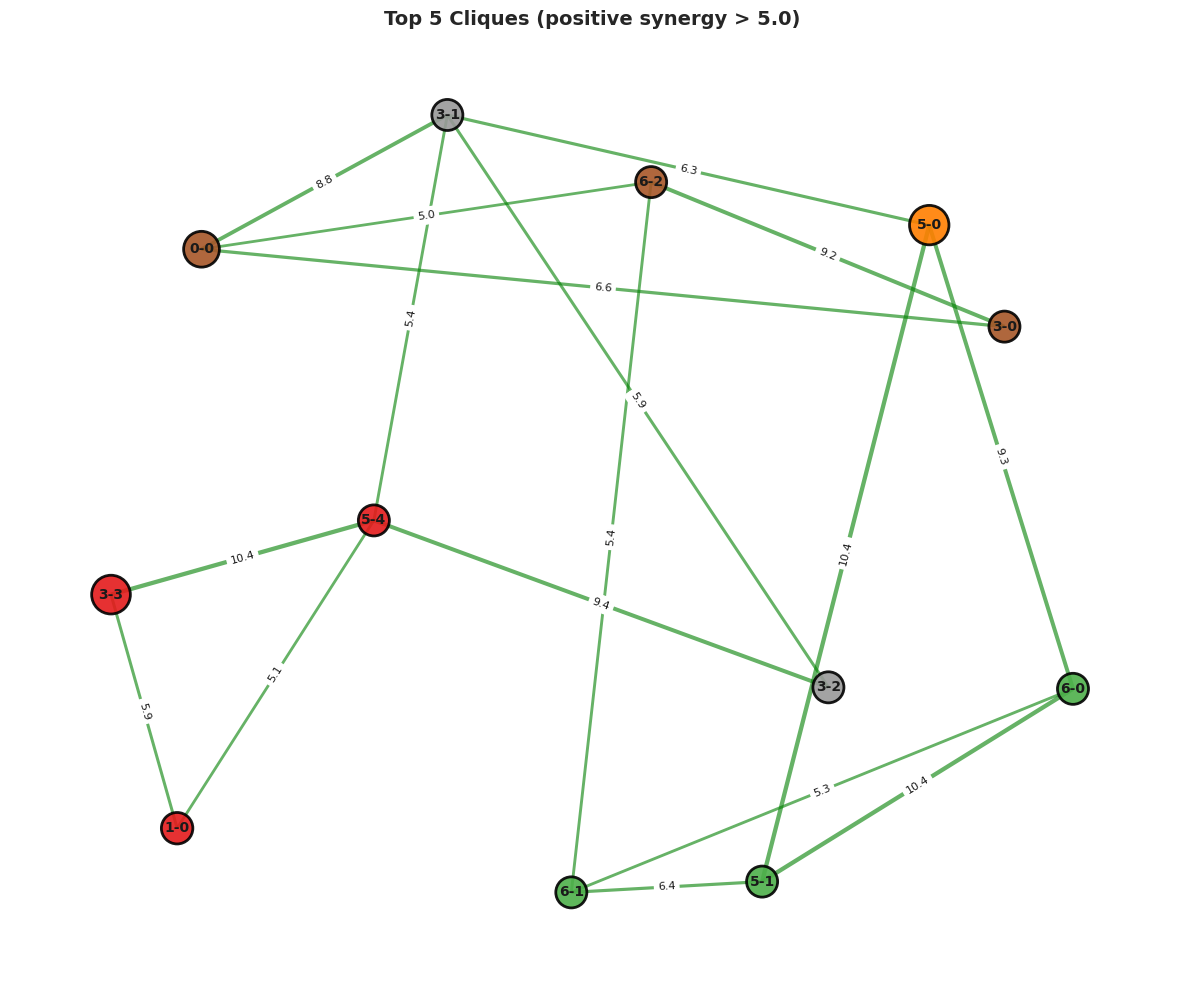

In [7]:
# Visualize the subgraph containing top cliques
top_cliques = cliques_3plus[:5] if len(cliques_3plus) >= 5 else cliques_3plus

# Get all nodes in top cliques
clique_nodes = set()
for clique in top_cliques:
    clique_nodes.update(clique)

# Create subgraph
G_sub = G_pos.subgraph(clique_nodes)

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G_sub, k=2.0, seed=42)

# Color nodes by which clique they belong to
clique_colors = plt.cm.Set1(np.linspace(0, 1, len(top_cliques)))
node_colors = []
for node in G_sub.nodes():
    for i, clique in enumerate(top_cliques):
        if node in clique:
            node_colors.append(clique_colors[i])
            break
    else:
        node_colors.append('gray')

# Node sizes by single effect
node_sizes = [500 + 50 * max(0, single_effect_lookup.get(n, 0)) for n in G_sub.nodes()]

nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes,
                        alpha=0.9, edgecolors='black', linewidths=2, ax=ax)

# Edge widths by synergy
edge_widths = [1 + 0.2 * G_sub[u][v]['synergy'] for u, v in G_sub.edges()]
nx.draw_networkx_edges(G_sub, pos, width=edge_widths, edge_color='green', alpha=0.6, ax=ax)

nx.draw_networkx_labels(G_sub, pos, font_size=10, font_weight='bold', ax=ax)

# Edge labels
edge_labels = {(u, v): f"{d['synergy']:.1f}" for u, v, d in G_sub.edges(data=True)}
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels, font_size=8, ax=ax)

ax.set_title(f'Top {len(top_cliques)} Cliques (positive synergy > {SYNERGY_THRESHOLD})', 
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig('../../results/figures/16e_top_cliques.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

## 5. Node Participation in Cliques

In [8]:
# Count how many cliques each domino participates in
participation = Counter()
for clique in cliques_3plus:
    for domino in clique:
        participation[domino] += 1

print("\nDomino participation in cliques (size >= 3):")
print("=" * 50)
for domino, count in participation.most_common(15):
    is_dbl = "[D]" if G_pos.nodes[domino]['is_double'] else "   "
    effect = single_effect_lookup.get(domino, 0)
    print(f"{domino:5} {is_dbl}: {count:3} cliques (single effect: {effect:+.1f})")


Domino participation in cliques (size >= 3):
5-4      :   2 cliques (single effect: -3.8)
6-0      :   2 cliques (single effect: -9.5)
5-1      :   2 cliques (single effect: -1.4)
1-0      :   1 cliques (single effect: +0.3)
3-3   [D]:   1 cliques (single effect: +5.6)
6-1      :   1 cliques (single effect: -0.7)
5-0      :   1 cliques (single effect: +6.1)
6-2      :   1 cliques (single effect: -4.2)
0-0   [D]:   1 cliques (single effect: +3.3)
3-0      :   1 cliques (single effect: -2.1)
3-1      :   1 cliques (single effect: -4.7)
3-2      :   1 cliques (single effect: -3.0)


## 6. Save Results

In [9]:
# Save clique data
if len(clique_df) > 0:
    output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16e_cliques.csv"
    clique_df.to_csv(output_path, index=False)
    print(f"Saved {len(clique_df)} cliques to {output_path}")
else:
    print("No cliques of size >= 3 found")

# Save participation counts
participation_df = pd.DataFrame([
    {'domino': d, 'clique_count': c, 'is_double': G_pos.nodes[d]['is_double'],
     'single_effect': single_effect_lookup.get(d, 0)}
    for d, c in participation.items()
]).sort_values('clique_count', ascending=False)

output_path2 = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16e_clique_participation.csv"
participation_df.to_csv(output_path2, index=False)
print(f"Saved participation to {output_path2}")

Saved 5 cliques to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16e_cliques.csv
Saved participation to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16e_clique_participation.csv


## Key Findings

### Clique Analysis

Cliques represent groups of dominoes where **every pair** has positive synergy above threshold. These could represent "strategic units" that work well together.

### Limitations

- Clique detection is sensitive to threshold choice
- Small sample size (200 hands) limits synergy precision
- Cliques don't account for hand constraints (can't have >7 dominoes)

### Interpretation

If cliques emerge, they suggest domino combinations that amplify each other. If few cliques exist, it confirms the additive model from 16c.

### Output Files

- `results/tables/16e_cliques.csv` - Clique list with stats
- `results/tables/16e_clique_participation.csv` - Per-domino participation
- `results/figures/16e_top_cliques.png` - Visualization